
# Data Description

This dataset contains an anonymized set of features, feature_{0...129}, representing real stock market data. Each row in the dataset represents a trading opportunity, for which you will be predicting an action value: 1 to make the trade and 0 to pass on it. Each trade has an associated weight and resp, which together represents a return on the trade. The date column is an integer which represents the day of the trade, while ts_id represents a time ordering. In addition to anonymized feature values, you are provided with metadata about the features in features.csv.

In the training set, train.csv, you are provided a resp value, as well as several other resp_{1,2,3,4} values that represent returns over different time horizons. These variables are not included in the test set. Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

This is an extensive data analysis for the jane street market dataset, this notebook will go through the train and features csv's for an extensive exploratory data analysis, Also some data cleaning and preprocessing will be done along the way



# About me

Working as Data Scientist in IT firm in Pakistan. I was Recently Enguaged with Radix Trading LLC which is a firm just like Jane Street which also work in High frequency algorithmic trading. Where i worked as Quantitative Researcher (Quant) to Capture Price movement in High frequency Algorithmic trading through Alphas. Designed many successful Alpha/strategies which is trade-able in real Stock market. For more details kindly visit my linkedin profile.

Please upvote if you find this notebook helpful! 😊 Thank you! I would also be very happy to receive feedback on my work.


In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)
import datatable as dt
# misc
import missingno as msno
# system
import warnings
warnings.filterwarnings('ignore')
# garbage collector to keep RAM in check
import gc  
import matplotlib.gridspec as gridspec

In [ ]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

import seaborn as sns
class myjoint(sns.JointGrid):
    def __init__(self, x, y, data=None,height=7, ratio=5, space=.2,
                 dropna=True, xlim=None, ylim=None, size=None):
        super(myjoint, self).__init__(x, y, data,height, ratio, space,
                 dropna, xlim, ylim, size)
        plt.close(2)
        # Set up the subplot grid
        self.ax_joint = f.add_subplot(gs[1:, :-1])
        self.ax_marg_x = f.add_subplot(gs[0, :-1], sharex=self.ax_joint)
        self.ax_marg_y = f.add_subplot(gs[1:, -1], sharey=self.ax_joint)

        # Turn off tick visibility for the measure axis on the marginal plots
        plt.setp(self.ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(self.ax_marg_y.get_yticklabels(), visible=False)

In [ ]:
!wc -l ../input/jane-street-market-prediction/train.csv
!wc -l ../input/jane-street-market-prediction/features.csv
!wc -l ../input/jane-street-market-prediction/example_sample_submission.csv
!wc -l ../input/jane-street-market-prediction/example_test.csv

In [ ]:
train_data = dt.fread('../input/jane-street-market-prediction/train.csv').to_pandas()
features_data = dt.fread('../input/jane-street-market-prediction/features.csv').to_pandas()
example_sample_submission = dt.fread('../input/jane-street-market-prediction/example_sample_submission.csv').to_pandas()
example_test = dt.fread('../input/jane-street-market-prediction/example_test.csv').to_pandas()
type(train_data)

# Data Overview

In [ ]:
train_data.head()

In [ ]:
train_data.describe()

In [ ]:
example_sample_submission.head()

In [ ]:
example_test.head()

# Cumulative Return of resp

### Lets see Trends of resp

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_ylabel ("Cumulative return", fontsize=18);
balance.plot(lw=3);

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
resp_1= pd.Series(train_data['resp_1']).cumsum()
resp_2= pd.Series(train_data['resp_2']).cumsum()
resp_3= pd.Series(train_data['resp_3']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return of resp", fontsize=18)
balance.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend(loc="upper left");

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
resp_4= pd.Series(train_data['resp_4']).cumsum() 
resp_3= pd.Series(train_data['resp_3']).cumsum()
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return of resp and time horizons 4 and 3 (500 days)", fontsize=18)
balance.plot(lw=3)
resp_4.plot(lw=3) 
resp_3.plot(lw=3)
plt.legend(loc="upper left");

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
balance= pd.Series(train_data['resp']).cumsum()
weighted_trend= pd.Series(train_data['weight']*train_data['resp'],name='weighted_trend').cumsum()  
ax.set_xlabel ("Trade", fontsize=18)
ax.set_title ("Cumulative return of resp and weighted_trend", fontsize=18)
balance.plot(lw=3)
weighted_trend.plot(lw=3) 
plt.legend(loc="upper left");

In [ ]:
train_data['resp_trend'] = train_data['resp'].cumsum()                                                              
train_data['weighted_trend'] = (train_data['weight']*train_data['resp']).cumsum()                                   
train_data.plot(x='ts_id', y=['resp_trend', 'weighted_trend'],figsize=(15,5))   
plt.show()

Due to itraday trading patterns in High Frequency Algorithmic Trading.So thats why i have decided to look at only one data of data for my Explaintory Data Analysis

In [ ]:
# Taking one day sample data from train dataset date 1
sample_train_data = train_data.query('date == 1')
sample_train_data.describe()

# Handling Null Values

In [ ]:
# missing values
n_features = 60
nan_val = train_data.isna().sum()[train_data.isna().sum() > 0].sort_values(ascending=False)
print(nan_val)
fig, axs = plt.subplots(figsize=(10, 10))
sns.barplot(y = nan_val.index[0:n_features], 
            x = nan_val.values[0:n_features], 
            alpha = 0.8
           )
plt.title('Missing values of train dataset')
plt.xlabel('# of Missing values')
plt.show()

In [ ]:
#Finding out the features with missing values more than 10%
null = sample_train_data.isnull().sum()
nulls_fl = list(null[null >(0.1 * len(sample_train_data))].index)
nulls_fl

In [ ]:
print("Number of features with null values:",np.sum(train_data.isna().sum()>0))

In [ ]:
#Here i am using median value to replace missing values as Median is not affected by outliers.
#Missing Data Handling
train_data = train_data.apply(lambda x: x.fillna(x.mean()),axis=0)
print("Number of features with null values:",np.sum(train_data.isna().sum()>0))

In [ ]:
#Here i am using median value to replace missing values as Median is not affected by outliers.
#Missing Data Handling
sample_train_data = sample_train_data.apply(lambda x: x.fillna(x.mean()),axis=0)
print("Number of features with null values:",np.sum(sample_train_data.isna().sum()>0))

### Now we can take a bird's-eye view of features distributions

In [ ]:
sample_train_data.iloc[:,7:-2].hist(bins=100,figsize=(30,74),layout=(35,4));

Above Distribution of dataset it seems that most of the features are Normally distributed (Standardized) and they are mean/Zero reverted

**Now we make a boxplot grid again with customized .1% : 99.9% whiskers of sample data.**

In [ ]:
featstr = [i for i in train_data.columns[7:-2]]
fig = plt.figure(figsize=(20,80))
fig.suptitle('Features Box plot with 0.1% 99.9% whiskers',fontsize=22, y=.89)
grid =  gridspec.GridSpec(29,4,figure=fig,hspace=.5,wspace=.05)
counter = 0
for i in range(29):
    for j in range(4):
        subf = fig.add_subplot(grid[i, j]);
        sns.boxplot(x= sample_train_data[featstr[counter]],saturation=.5,color= 'blue', ax= subf,width=.5,whis=(.1,99.9));
        subf.set_xlabel('')
        subf.set_title('{}'.format(featstr[counter]),fontsize=16)
        counter += 1
        gc.collect();

# Weights

Analyze the distibution of feature "weight"


In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.distplot(sample_train_data["weight"],color='green')

In [ ]:
y = sns.JointGrid(data=sample_train_data, x="weight", y="resp")
y.plot_joint(sns.scatterplot, s=100, alpha=.5)
y.plot_marginals(sns.distplot, kde=True,color='orange')

In [ ]:
sns.scatterplot(data=sample_train_data, x='resp',y='weight', color= 'green', alpha=.3)
plt.title('Resp vs Weight\ncorrelation={}'.format(round(sample_train_data.weight.corr(sample_train_data.resp),4)));

In [ ]:
sns.scatterplot(data=train_data, x='resp',y='weight', color= 'blue', alpha=.3)
plt.title('Resp vs Weight\ncorrelation={}'.format(round(train_data.weight.corr(train_data.resp),4)));

* **Lower weight trades have a much higher dispersion in resp.**
* **This implies that weight is some kind of predictor of future return volatility**.

# Linear Regression analysis weight vs resp

In [ ]:
ratio=4
f = plt.figure(figsize=(25,60))
outer_grid = gridspec.GridSpec(7, 3, wspace=0.3, hspace=0.3)
for i, column in enumerate(['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']):
    gs = gridspec.GridSpecFromSubplotSpec(ratio+1, ratio+1,
            subplot_spec=outer_grid[i], wspace=0.3, hspace=0.3)
    g = myjoint(y="weight", x=column, data=train_data, ratio=ratio)
    g = g.plot(sns.regplot, sns.distplot)
    r2_score = r2(x=train_data[column],y=train_data["weight"])
    plt.xlabel(f"{column} R2 score:{round(r2_score,4)}")


Negitive relation between weight and resp(target variable) can be seen in Linear Regression analysis above.

# Resp
resp is predictive variable. Here i will tried to analyze this group of variables to find out valueable insights.

In [ ]:
sample_train_data.iloc[:,2:7].hist(bins=100,figsize=(20,20),color='#ff6645');

### Distribution shows that all of these resp features are perfectly zero reverted**

Bird view of resp features with pair plot

In [ ]:
sns.pairplot(sample_train_data[['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']],corner=True);

### Coorelation charts of resp features

In [ ]:
sns.heatmap(sample_train_data[['resp','resp_1','resp_2','resp_3','resp_4']].corr(), annot = True)

In [ ]:
sns.heatmap(sample_train_data[['resp','resp_1','resp_2','resp_3','resp_4','weight']].corr(), annot = True, vmin=-1, vmax=1, center= 0)

**Coorelation charts of resp with features list having missing values more then 10%****

In [ ]:
sample_train_data[['resp','resp_1','resp_2','resp_3','resp_4','weight']+nulls_fl].corr().style.background_gradient(cmap='coolwarm')

# Features and resp Correlation

In [ ]:
respcorr =  pd.Series([train_data.resp.corr(train_data[i]) for i in featstr],index=featstr)

In [ ]:
fig = px.bar(respcorr,color = respcorr, color_continuous_scale=['red','blue'], title= 'Features Correlation with Resp')
fig.layout.xaxis.tickangle = 300
fig.layout.xaxis. dtick = 5
fig.layout.xaxis.title = ''
fig.layout.yaxis.title = 'pearson correlation'
fig.update(layout_coloraxis_showscale=False)
fig.show();

#### We can see that features are not really correlated to Resp

# Features and Weight


In [ ]:
#taking in consideration weights larger than 0
wcorr = pd.Series([train_data[train_data.weight != 0].weight.corr(train_data[train_data.weight != 0][i]) for i in featstr],index=featstr)
wcorr.head()

In [ ]:
fig = px.bar(wcorr,title= 'Features Correlation with Weight (not including zero weights)')
fig.layout.xaxis.tickangle = 300
fig.layout.xaxis. dtick = 5
fig.layout.xaxis.title = ''
fig.layout.yaxis.title = 'pearson correlation'
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(showlegend=False)
fig.show()

we see with highest correlation which belongs to features 51

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(train_data[train_data.weight != 0].weight,train_data[train_data.weight != 0].feature_51, color = 'orange', alpha=.3)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Featre_51',fontsize=14)
plt.title('Feature_51 vs Weight\nCorrelation = {}%'.format(round(train_data[train_data.weight != 0].weight.corr(train_data[train_data.weight != 0].feature_51),4)*100),fontsize=16);

 Second highest correlation which belongs to features 50


In [ ]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(train_data[train_data.weight != 0].weight,train_data[train_data.weight != 0].feature_50, color = 'orange', alpha=.3)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Featre_50',fontsize=14)
plt.title('Feature_50 vs Weight\nCorrelation = {}%'.format(round(train_data[train_data.weight != 0].weight.corr(train_data[train_data.weight != 0].feature_50),4)*100),fontsize=16);

Now we check the lowest correlation

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(train_data[train_data.weight != 0].weight,train_data[train_data.weight != 0].feature_126, color = 'darkblue', alpha=.3)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Featre_126',fontsize=14)
plt.title('Feature_126 vs Weight\nCorrelation{}%'.format(round(train_data[train_data.weight != 0].weight.corr(train_data[train_data.weight != 0].feature_126),4)*100),fontsize=16);

there is some kind negative correlation between weight and feature 126 the relation seem to be weak

# Creating Groups of features on the basic of coorelation with respect to res


In [ ]:
respcorr =  pd.Series([train_data.resp.corr(train_data[i]) for i in featstr],index=featstr,name="cor").to_frame()
group_01 = respcorr.loc[(respcorr["cor"] > 0.02) & (respcorr["cor"] < 0.03) ]
group_01.head()

In [ ]:
group_02 = respcorr.loc[(respcorr["cor"] >= 0.03)]
group_02

# Group 01 w.r.t corr

This Group included features that are created on basic of coorelation between 0.02 to 0.03 with respect to res .

## Correlation Analysis of Group 01

In [ ]:
class myjoint(sns.JointGrid):
    def __init__(self, x, y, data=None,height=7, ratio=5, space=.2,
                 dropna=True, xlim=None, ylim=None, size=None):
        super(myjoint, self).__init__(x, y, data,height, ratio, space,
                 dropna, xlim, ylim, size)
        plt.close(2)
        # Set up the subplot grid
        self.ax_joint = f.add_subplot(gs[1:, :-1])
        self.ax_marg_x = f.add_subplot(gs[0, :-1], sharex=self.ax_joint)
        self.ax_marg_y = f.add_subplot(gs[1:, -1], sharey=self.ax_joint)
        # Turn off tick visibility for the measure axis on the marginal plots
        plt.setp(self.ax_marg_x.get_xticklabels(), visible=False)
        plt.setp(self.ax_marg_y.get_yticklabels(), visible=False)

In [ ]:
corr = sample_train_data[group_01.index].corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='BrBG',  center=0,vmin=-1, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
fig, axes = plt.subplots(nrows=3
                         , ncols=3,figsize=(20,22))
for i, column in enumerate(group_01.index):
    sns.distplot(sample_train_data[column],ax=axes[i//3,i%3],color='blue')

## Linear Regression Analysis of Group 01

* Here i am going to find out the relationship between features of Group 01 and resp.

In [ ]:
ratio=4
f = plt.figure(figsize=(25,60))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, column in enumerate(group_01.index):
    gs = gridspec.GridSpecFromSubplotSpec(ratio+1, ratio+1,
            subplot_spec=outer_grid[i], wspace=0.3, hspace=0.3)
    g = myjoint(y="resp", x=column, data=sample_train_data, ratio=ratio)
    g = g.plot(sns.regplot, sns.distplot )
    r2_score = r2(x=sample_train_data[column],y=sample_train_data["resp"])
    plt.xlabel(f"{column} R2 score:{round(r2_score,4)}")

**Relation between features and resp(target variable) is Present in Linear Regression analysis above**

* Positive relation between features 122,34,40,53,32 and resp(target variable) can be seen in Linear Regression analysis above.
* Feature 34 has highest R2 score in this Group of 0.0321. 
* Features 11 has lowest R2 score of 0.0 in this Group of features.
* We can see from the distribution is that all 5 of these resp features are perfectly zero reverted.

# Group 02 w.r.t corr

This Group included features that are created on basic of coorelation grater then 0.03 with respect to res .

## Correlation Analysis of Group 02

In [ ]:
corr = sample_train_data[group_02.index].corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='BrBG',  center=0,vmin=-1, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20,22))
for i, column in enumerate(group_02.index):
    sns.distplot(sample_train_data[column],ax=axes[i//3,i%3],color='gray')

## Linear Regression Analysis of Group 02

*     Here i am going to find out the relationship between features of Group 02 and resp.


In [ ]:
ratio=4
f = plt.figure(figsize=(25,60))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, column in enumerate(group_02.index):
    gs = gridspec.GridSpecFromSubplotSpec(ratio+1, ratio+1,
            subplot_spec=outer_grid[i], wspace=0.3, hspace=0.3)
    g = myjoint(y="resp", x=column, data=sample_train_data, ratio=ratio)
    g = g.plot(sns.regplot, sns.distplot)
    r2_score = r2(x=sample_train_data[column],y=sample_train_data["resp"])
    plt.xlabel(f"{column} R2 score:{round(r2_score,4)}")

**Relation between features and resp(target variable) is Present in Linear Regression analysis above**

*     Positive relation between features 27,28,29,31,33,35 and resp(target variable) can be seen in Linear Regression analysis above.
*     Feature 29 has highest R2 score in this Group of 0.0726.
*     Features 28 has lowest R2 score of 0.2 in this Group of features.
*     We can see from the distribution is that all 5 of these resp features are perfectly zero reverted.



# Features Anslysis from LightGBM model

* Below picture is the feature importance clustering of LightGBM Model.
* The darker labels represent features that have higher feature importance in the LightGBM model.
* This picture is taken from some other notebook link is given in references.

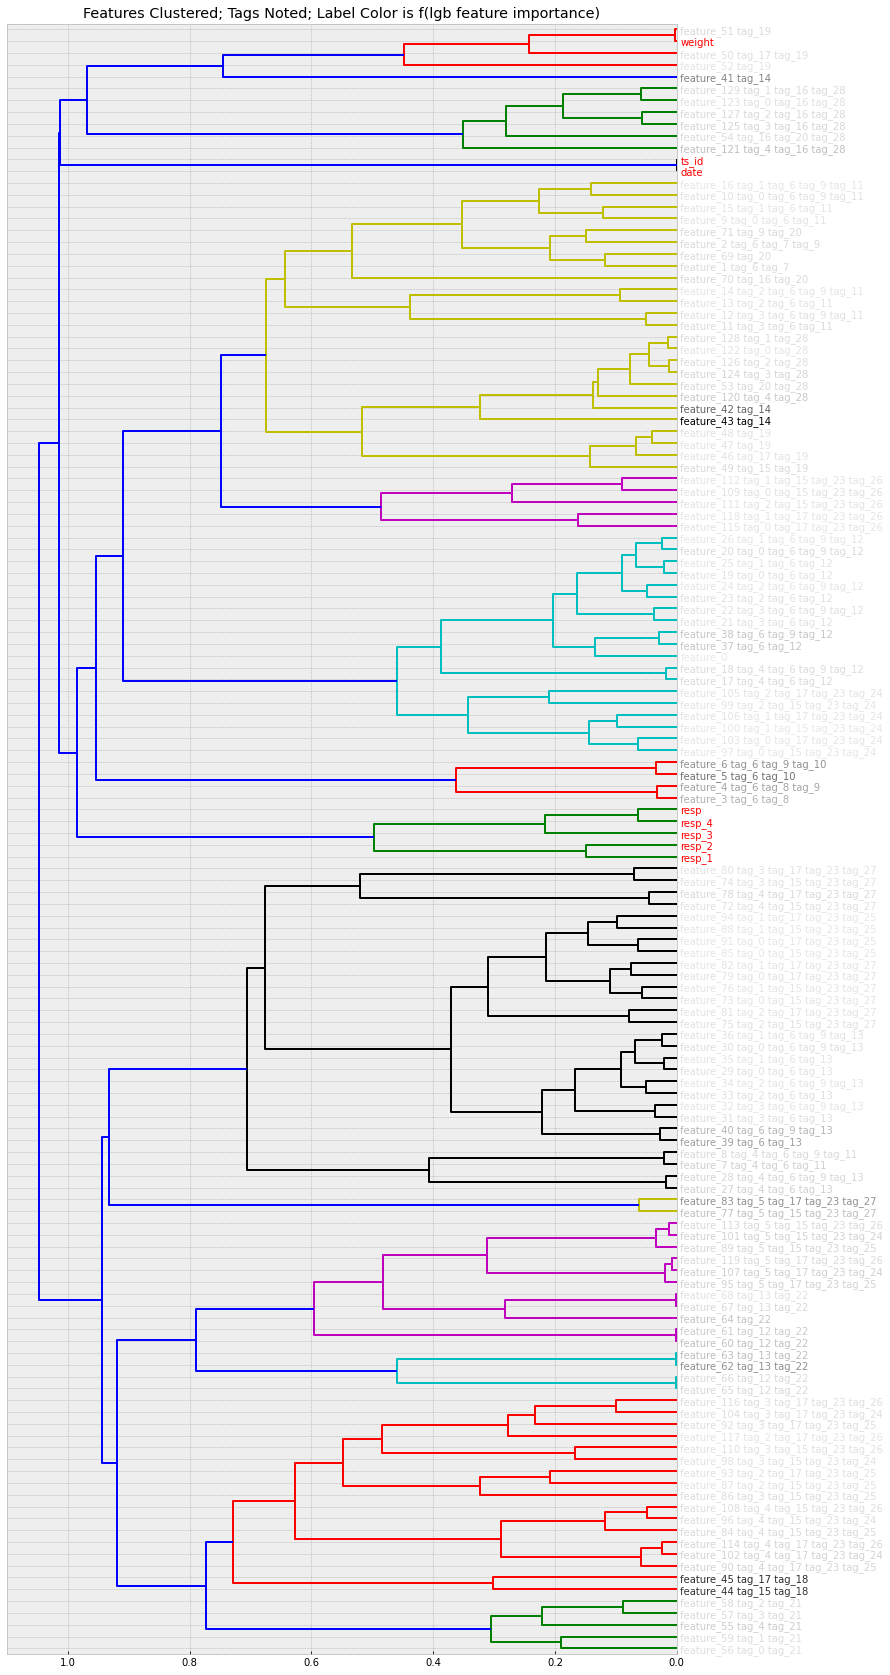

# Tag 18 Group Featues

In [ ]:
fig, ax = plt.subplots(2,figsize=(10, 6))
ax[0].scatter(train_data["feature_45"], train_data["resp"],color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 0.7);
ax[1].scatter(train_data["feature_44"], train_data["resp"],color = "black", edgecolors = "white", linewidths = 0.1, alpha = 0.5);

These features pair which shows there is redundant information we can drop one feature.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
for i, column in enumerate(["feature_45","feature_44"]):
    sns.distplot(sample_train_data[column],ax=axes[i],color='gray')

In [ ]:
ratio=4
f = plt.figure(figsize=(25,60))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, column in enumerate(["feature_45","feature_44"]):
    gs = gridspec.GridSpecFromSubplotSpec(ratio+1, ratio+1,
            subplot_spec=outer_grid[i], wspace=0.3, hspace=0.3)
    g = myjoint(y="resp", x=column, data=sample_train_data, ratio=ratio)
    g = g.plot(sns.regplot, sns.distplot)
    r2_score = r2(x=sample_train_data[column],y=sample_train_data["resp"])
    plt.xlabel(f"{column} R2 score:{round(r2_score,4)}")

These features 45 and 44 has lowest R2 score 0.0001 in Linear Regression analysis 

# Tag 6 Group Featues

Features 6, 3, 4, 5 belong to Tag 6 

In [ ]:
fig, ax = plt.subplots(4, figsize=(20, 10))
ax[0].scatter(train_data["feature_3"], train_data["resp"],color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 0.7);
ax[1].scatter(train_data["feature_4"], train_data["resp"],color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 0.5);
ax[2].scatter(train_data["feature_5"], train_data["resp"],color = "gray", edgecolors = "white", linewidths = 0.1, alpha = 0.7);
ax[3].scatter(train_data["feature_6"], train_data["resp"],color = "gray", edgecolors = "white", linewidths = 0.1, alpha = 0.5);

In [ ]:
ratio=4
f = plt.figure(figsize=(25,60))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, column in enumerate(["feature_3","feature_4","feature_5","feature_6"]):
    gs = gridspec.GridSpecFromSubplotSpec(ratio+1, ratio+1,
            subplot_spec=outer_grid[i], wspace=0.3, hspace=0.3)
    g = myjoint(y="resp", x=column, data=sample_train_data, ratio=ratio)
    g = g.plot(sns.regplot, sns.distplot)
    r2_score = r2(x=sample_train_data[column],y=sample_train_data["resp"])
    plt.xlabel(f"{column} R2 score:{round(r2_score,4)}")

# Tag 14 Group Featues

Features 42.43,41 belong to Tag 14 

In [ ]:
fig, ax = plt.subplots(3,figsize=(15, 6))
ax[0].scatter(train_data["feature_41"], train_data["resp"],color = "blue", edgecolors = "white", linewidths = 0.1, alpha = 0.7);
ax[1].scatter(train_data["feature_42"], train_data["resp"],color = "black", edgecolors = "white", linewidths = 0.1, alpha = 0.5);
ax[2].scatter(train_data["feature_43"], train_data["resp"],color = "black", edgecolors = "white", linewidths = 0.1, alpha = 0.5);

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,5))
for i, column in enumerate(["feature_41","feature_42","feature_43"]):
    sns.distplot(sample_train_data[column],ax=axes[i],color='gray')

In [ ]:
ratio=4
f = plt.figure(figsize=(25,60))
outer_grid = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, column in enumerate(["feature_41","feature_42","feature_43"]):
    gs = gridspec.GridSpecFromSubplotSpec(ratio+1, ratio+1,
            subplot_spec=outer_grid[i], wspace=0.3, hspace=0.3)
    g = myjoint(y="resp", x=column, data=sample_train_data, ratio=ratio)
    g = g.plot(sns.regplot, sns.distplot)
    r2_score = r2(x=sample_train_data[column],y=sample_train_data["resp"])
    plt.xlabel(f"{column} R2 score:{round(r2_score,4)}")

# PCA

In [ ]:
sample_train_data_pca = sample_train_data
sample_train_data_pca['action'] = np.where(sample_train_data['resp'] > 0,1,0)
sample_train_data_pca.action = sample_train_data_pca.action.astype('category')

In [ ]:
from sklearn.preprocessing import StandardScaler as scale
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from sklearn.model_selection import train_test_split as split 
from sklearn.model_selection import GridSearchCV as Grid

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
import optuna

In [ ]:
scaler = scale()

In [ ]:
scaler.fit(sample_train_data_pca[featstr[1:]])

In [ ]:
df_pca = pd.DataFrame(scaler.transform(sample_train_data_pca[featstr[1:]]))
df_pca.columns = featstr[1:]
gc.collect()
df_pca.head()

#### Reduce the dimensionality of the data to 8 principal components

In [ ]:
pca =  PCA(n_components= 10).fit(df_pca)
df_pca = pd.DataFrame(pca.transform(df_pca))

In [ ]:
pcs = ['pc'+str(i+1) for i in range(10)]

Adding weight, Resp and action to the new dataframe

In [ ]:
df_pca.columns = pcs
df_pca['action'] = sample_train_data_pca.action.values
df_pca['weight'] = sample_train_data_pca.weight.values
df_pca['resp'] = sample_train_data_pca.resp.values
df_pca.head()

correlation in the PCA dataframe

In [ ]:
df_pca.corr().style.background_gradient(cmap='coolwarm')

PCA did't really help as principal components still don't have a clear relation with resp

# Clustering

Exploring the possible clusters in the PCA dataframe

In [ ]:
kmeans = k_means(n_clusters= 10, max_iter= 400, random_state= 0,X=df_pca[pcs])
df_pca['cluster'] = kmeans[1]
df_pca['cluster'] = df_pca['cluster'].astype('category')
df_pca.head()

Plotting the relation between clusters and Resp

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)
sns.countplot(data=df_pca,x='cluster',hue='action',ax=ax,palette='viridis')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h,['Negative','Positive'],ncol= 1, fontsize= 12, loc= 1,title= 'Resp',title_fontsize=14)
plt.xlabel('Clusters',fontsize=18)
plt.ylabel('')
plt.xticks(fontsize=14) 
plt.title('PCA Clusters and Resp', fontsize=22);

Clusters seem to be also scattered with no clear relation between a cluster and resp

Component and Variance Graph

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### The first 10 principal components explains about 70% of the variation
### Lets increase pca size 

## PCA on All Data set

In [ ]:
train_data_pca = train_data
train_data_pca['action'] = np.where(train_data_pca['resp'] > 0,1,0)
train_data_pca.action = train_data_pca.action.astype('category')

In [ ]:

featstr = [i for i in train_data.columns[7:-2]]
scaler.fit(train_data_pca[featstr[1:]])
 
df_pca = pd.DataFrame(scaler.transform(train_data_pca[featstr[1:]]))
df_pca.columns = featstr[1:]
gc.collect()
df_pca.head()

In [ ]:
pca =  PCA(n_components= 40).fit(df_pca)
df_pca = pd.DataFrame(pca.transform(df_pca))

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### The first 40 principal components explains about 95% of the variation

In [ ]:
X_train = train_data.loc[:, train_data.columns.str.contains('feature')]
y_train = train_data.loc[:, 'action']

In [ ]:
sns.set_palette("colorblind")
ax = sns.barplot(y_train.value_counts().index, y_train.value_counts()/len(y_train))
ax.set_title("Proportion of trades with action=0 and action=1")
ax.set_ylabel("Percentage")
ax.set_xlabel("Action")
sns.despine();
#Data Is balanced for modeling 


## Findings:

Based on my Experience as Quantative Researcher it is come to my knowledge that itraday trading patterns in High Frequency Algorithmic Trading are far more linked than iterday Patterns. Since not enough information is given about these features.These packets come in market can be any type usually the main type of packets that we receive of different instrument from stock exchange are about Trade, Delete, update, Reduce Messages Packets about changes in order book.

Looking at the Distribution of dataset it seems that most of the features are Normally distributed (Standardized) and they are mean/Zero reverted. Later i will try to analyze these features using different categories.

By looking mutiple features distibution we can said that they are using Zero Mean Reverted Startgies in Trading.

By looking at the Feature 0 it has two distinct values 0,1 it seems that it is a trading signal.

Looking at the Histogram of features from it seems that dataset has has been provided has features that are Zero reverted.

All the feature that are in same tag has some correlation with each other.

**I am going to add lot of things (and remember that work in still in progress).**

### Referrences

* https://www.kaggle.com/marketneutral/jane-street-eda-regime-tags-clusters
* https://www.kaggle.com/hamzashabbirbhatti/eda-a-quant-s-prespective